In [42]:
import psycopg2

connection = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret',
)

In [38]:
cursor = connection.cursor()
cursor.execute(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE created_at >= CURRENT_DATE - INTERVAL '1 year'
    GROUP BY registration_day
    ORDER BY registration_day
    """
    )
data = cursor.fetchall()

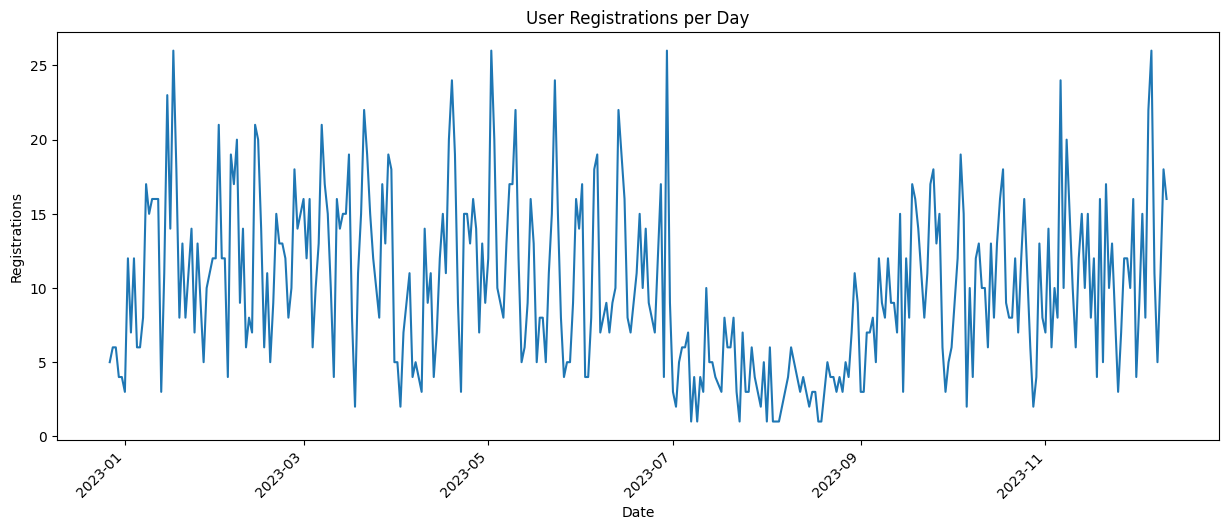

In [41]:
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

dates = [row[0] for row in data]
registrations = [row[1] for row in data]

plt.figure(figsize=(15, 6))
plt.plot(dates, registrations)
plt.gcf().autofmt_xdate()
plt.title('User Registrations per Day')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.xticks(rotation=45)
plt.show()